In [1]:
import numpy as np
import pandas as pd
#from scipy.stats import describe 
from scipy.stats import pearson3
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm
from scipy.optimize import minimize

### Optimization of Expected Growth Rate Using Simulated Returns

### Box 8.1

We assume that the strategy daily returns are contained in the Nx1 array *ret*. We will use the first four moments of ret to generate a Pearson system distribution, from which any number of simulated returns *ret_sim* can be generated.

In [2]:
df=pd.read_csv('AUDCAD_unequal_ret.csv')
df.head()

,Return
0,0.000000
1,-0.006514
2,-0.005079
3,-0.003791
4,0.002169


In [3]:
skew_, loc_, scale_=pearson3.fit(df) 
print('skew=%f loc=%f scale=%f' % (skew_, loc_, scale_))
mean,var,skew,kurt=pearson3.stats(skew_, loc_, scale_, moments='mvks')
print('mean=%f var=%f skew=%f kurt=%f' % (mean, var, skew, kurt))

skew=0.122820 loc=0.000432 scale=0.004231
mean=0.000432 var=0.000018 skew=0.122820 kurt=0.022627


In [4]:
ret_sim=pearson3.rvs(skew_, loc_, scale_, size=100000, random_state=0)
ret_sim

array([ 0.00807772,  0.00205133,  0.00854858, ...,  0.00290414,
       -0.0005581 ,  0.00031745])

### Box 8.2

An inline function for calculating the compounded growth rate based on leverage $f$ and return per bar of $R$.

<Axes: xlabel='f', ylabel='g'>

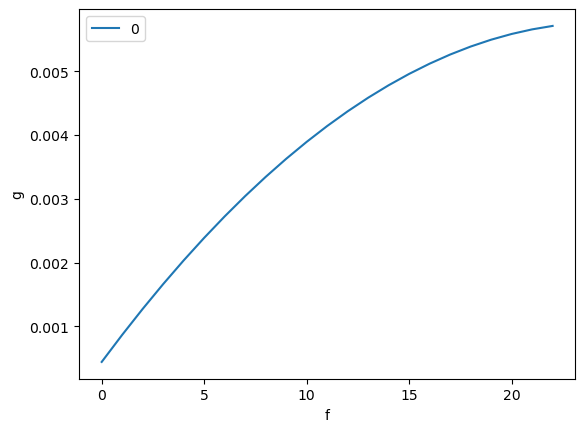

In [5]:
def g(f, R):
    return np.sum(np.log(1+f*R), axis=0)/R.shape[0]

myf=range(1, 24)
myg=np.full(24, np.NaN)

for f in myf:
    myg[f]=g(f, ret_sim)

myg=myg[1:]
myg=pd.DataFrame(myg)
myg.plot(xlabel='f', ylabel='g')

**FIGURE 8.2** Expected Growth Rate g as Function of f.

### Box 8.3

Finding the minimum of the negative of the growth rate based on leverage $f$ and the simulated returns *ret_sim* (same as finding the maximum of the positive growth rate).

In [6]:
minusG = lambda f : -g(f, df)
minusGsim = lambda f : -g(f, ret_sim)

#optimal leverage based on simulated returns
res = minimize(minusGsim, 0, method='Nelder-Mead')
optimalF=res.x
print('Optimal leverage=%f optimal growth rate=%f' % (optimalF, -res.fun))

Optimal leverage=25.512625 optimal growth rate=0.005767


In [7]:
minR=np.min(ret_sim)
print('minR=%f' % (minR))

minR=-0.018201


### Optimization of Historical Growth Rate

### Box 8.4

Finding the minimum of the negative of the growth rate based on leverage $f$ and the historical returns *ret*.

In [8]:
res = minimize(minusG, 0, method='Nelder-Mead')
optimalF=res.x
print('Optimal leverage=%f optimal growth rate=%f' % (optimalF, -res.fun))

Optimal leverage=23.721750 optimal growth rate=0.005198


In [9]:
minR=np.min(df.values)
print('minR=%f' % (minR))

minR=-0.022031


### Maximum Drawdown

### Box 8.5

Using my function [calculateMaxDD](https://github.com/usunyu/quant-for-fortune/blob/main/Algorithmic%20Trading%20-%20Winning%20Strategies%20and%20Their%20Rationale/calculateMaxDD.py) to compute maximum drawdowns with different leverages on the same simulated returns series *ret_sim*.

In [10]:
from calculateMaxDD import calculateMaxDD

In [11]:
# max drawdown with optimal leverage
maxDD, maxDDD, i=calculateMaxDD((np.cumproduct(1+optimalF*ret_sim)-1))
print('Max DD=%f with optimal leverage=%f' % (maxDD, optimalF))

Max DD=-0.993758 with optimal leverage=23.721750


In [12]:
#max drawdown with half of optimal leverage
maxDD, maxDDD, i=calculateMaxDD((np.cumproduct(1+optimalF/2*ret_sim)-1))
print('Max DD=%f with half optimal leverage=%f' % (maxDD, optimalF/2))

Max DD=-0.879011 with half optimal leverage=11.860875


In [13]:
# max drawdown with 1/7 of optimal leverage
maxDD, maxDDD, i=calculateMaxDD((np.cumproduct(1+optimalF/7*ret_sim)-1))
print('Max DD=%f with half optimal leverage=%f' % (maxDD, optimalF/7))

Max DD=-0.405211 with half optimal leverage=3.388821


In [14]:
#max drawdown with 1/1.4 of optimal leverage for historical returns
maxDD, maxDDD, i=calculateMaxDD((np.cumproduct(1+optimalF/1.4*df.values)-1))
print('Max DD=%f with historical returns=%f' % (maxDD, optimalF/1.4))

Max DD=-0.595425 with historical returns=16.944107
